# Hurricane Damage Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
!gdown 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

Downloading...
From (uriginal): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
From (redirected): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK&confirm=t&uuid=9f7b5bcd-2c00-4b0f-a47d-9474764ef44b
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:01<00:00, 21.8MB/s]


In [3]:
!unzip -q hurricane_detector.zip

In [4]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 Jun 24 18:52 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Jun 23 01:15 sample_data/
drwxr-xr-x 4 root root     4096 Jun 24 18:52 test_hurricane/
drwxr-xr-x 4 root root     4096 Jun 24 18:52 train_hurricane/


In [5]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 1s (53.6 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 123069 files and directories currently install

In [6]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage [655 entries exceeds filelimit, not opening dir]
└── no_damage [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage [5895 entries exceeds filelimit, not opening dir]
└── no_damage [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Load Dependencies

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.12.0


In [9]:
tf.keras.utils.set_random_seed(seed = 42)

## Utility functions to create dataset generators

In [10]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane", # use data in test directory as train - train split
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane", # use data in test directory as train - validation split
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane", # use data in train directory as test
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [11]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 12228 files belonging to 2 classes.
Using 9783 files for training.
Found 12228 files belonging to 2 classes.
Using 2445 files for validation.


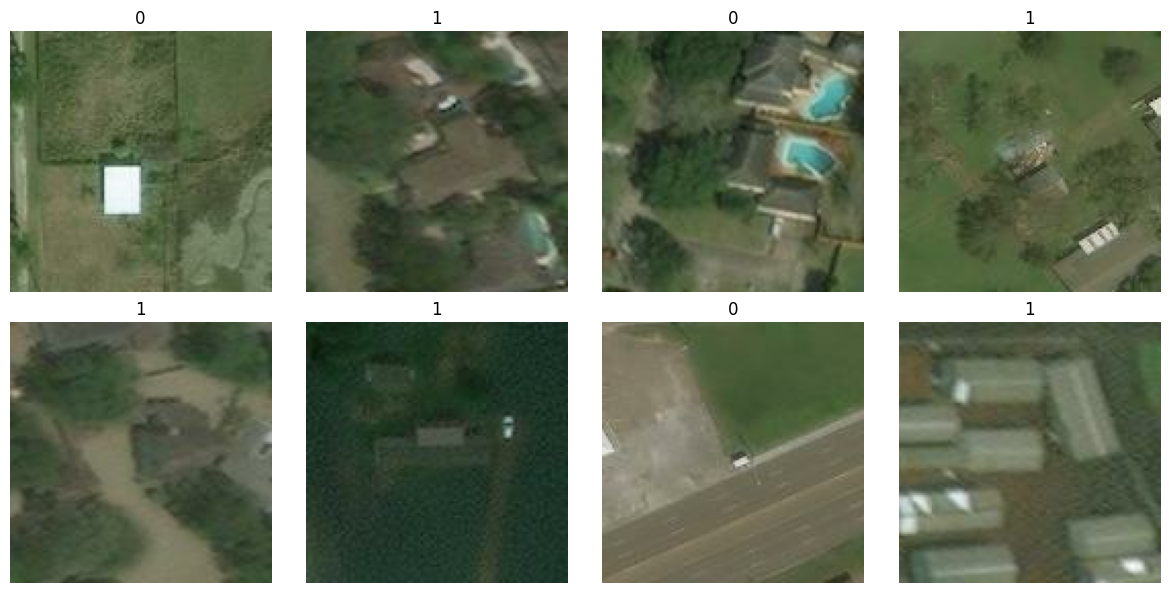

In [12]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

# Import libraries

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Experiments

## Experiment 1 - Basic CNN 1 (Cao & Choe, 2018)

This is the CNN architecture from the paper Cao & Choe (2018)

https://arxiv.org/pdf/1807.01688.pdf

**without**

* Data augmentation
* Dropout layer
* L2 Regularization

In [14]:
model = Sequential([

  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 3)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')

])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       7

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [17]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 10,
                                                  restore_best_weights = True)

epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [early_stopping_cb]
)

Epoch 1/30
306/306 [==============================] - 21s 28ms/step - loss: 0.4278 - accuracy: 0.7771 - val_loss: 0.2037 - val_accuracy: 0.9084
Epoch 2/30
306/306 [==============================] - 9s 28ms/step - loss: 0.1972 - accuracy: 0.9201 - val_loss: 0.1933 - val_accuracy: 0.9186
Epoch 3/30
306/306 [==============================] - 7s 22ms/step - loss: 0.1450 - accuracy: 0.9423 - val_loss: 0.1317 - val_accuracy: 0.9468
Epoch 4/30
306/306 [==============================] - 8s 25ms/step - loss: 0.1284 - accuracy: 0.9480 - val_loss: 0.1294 - val_accuracy: 0.9464
Epoch 5/30
306/306 [==============================] - 7s 22ms/step - loss: 0.0931 - accuracy: 0.9651 - val_loss: 0.1413 - val_accuracy: 0.9509
Epoch 6/30
306/306 [==============================] - 7s 22ms/step - loss: 0.0841 - accuracy: 0.9693 - val_loss: 0.1143 - val_accuracy: 0.9571
Epoch 7/30
306/306 [==============================] - 8s 26ms/step - loss: 0.0609 - accuracy: 0.9782 - val_loss: 0.1163 - val_accuracy: 0.957

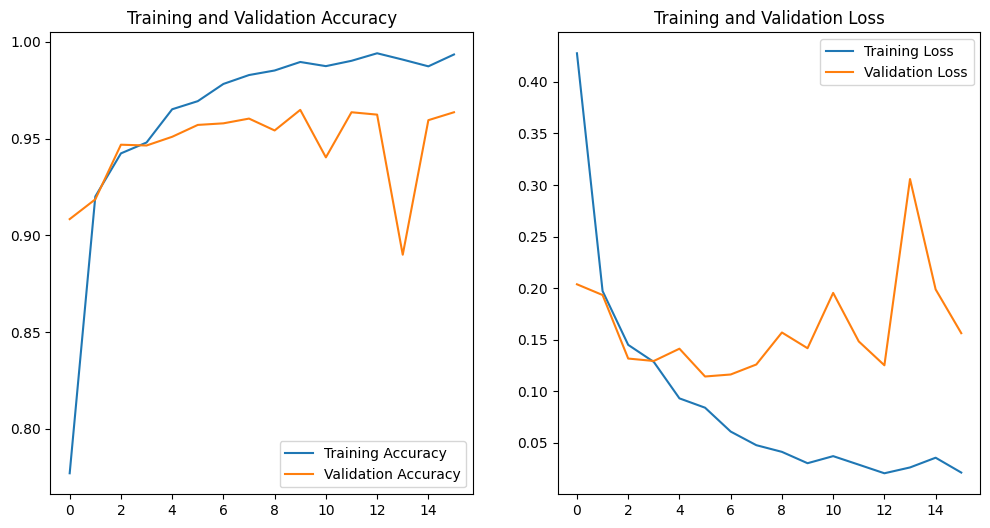

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
y_true, y_pred = eval_model_on_test(model)

Found 1358 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:05,  1.81it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:00<00:02,  3.13it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:01,  4.20it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  5.42it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  6.35it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:01<00:00,  6.79it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00,  7.06it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:01<00:00,  7.29it/s]

3/3 [==============================] - 1s 124ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]


In [20]:
y_pred = [1 if p > 0.5 else 0 for p in y_pred]

In [21]:
print(classification_report(y_true, y_pred,
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

   no_damage       0.96      0.95      0.95       703
      damage       0.95      0.95      0.95       655

    accuracy                           0.95      1358
   macro avg       0.95      0.95      0.95      1358
weighted avg       0.95      0.95      0.95      1358



,0,1
0,669,34
1,31,624


## Experiment 2 - Basic CNN 2 (Cao & Choe, 2018)

This is the CNN architecture from the paper Cao & Choe (2018)

https://arxiv.org/pdf/1807.01688.pdf

**adding their**

* Data augmentation
  * random rotation
  * horizontal flip
  * (vertical and horizontal shift) --> RandomTranslation
  * (shear) --> not clear how to add it using TF/Keras
  * zoom

**without**

* Dropout layer
* L2 Regularization

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    layers.experimental.preprocessing.RandomZoom(0.2)
    ])

In [23]:
model = Sequential([

    data_augmentation,

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')

    ])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)      

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 10,
                                                  restore_best_weights = True)

epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [early_stopping_cb]
)

Epoch 1/30
306/306 [==============================] - 12s 28ms/step - loss: 0.6167 - accuracy: 0.6185 - val_loss: 0.6982 - val_accuracy: 0.6311
Epoch 2/30
306/306 [==============================] - 8s 26ms/step - loss: 0.3351 - accuracy: 0.8609 - val_loss: 0.3201 - val_accuracy: 0.8573
Epoch 3/30
306/306 [==============================] - 9s 28ms/step - loss: 0.2426 - accuracy: 0.9057 - val_loss: 0.6087 - val_accuracy: 0.7370
Epoch 4/30
306/306 [==============================] - 9s 29ms/step - loss: 0.2305 - accuracy: 0.9068 - val_loss: 0.2680 - val_accuracy: 0.8969
Epoch 5/30
306/306 [==============================] - 9s 28ms/step - loss: 0.2108 - accuracy: 0.9171 - val_loss: 0.2033 - val_accuracy: 0.9174
Epoch 6/30
306/306 [==============================] - 8s 26ms/step - loss: 0.2039 - accuracy: 0.9216 - val_loss: 0.3131 - val_accuracy: 0.8658
Epoch 7/30
306/306 [==============================] - 9s 28ms/step - loss: 0.1991 - accuracy: 0.9216 - val_loss: 0.2370 - val_accuracy: 0.898

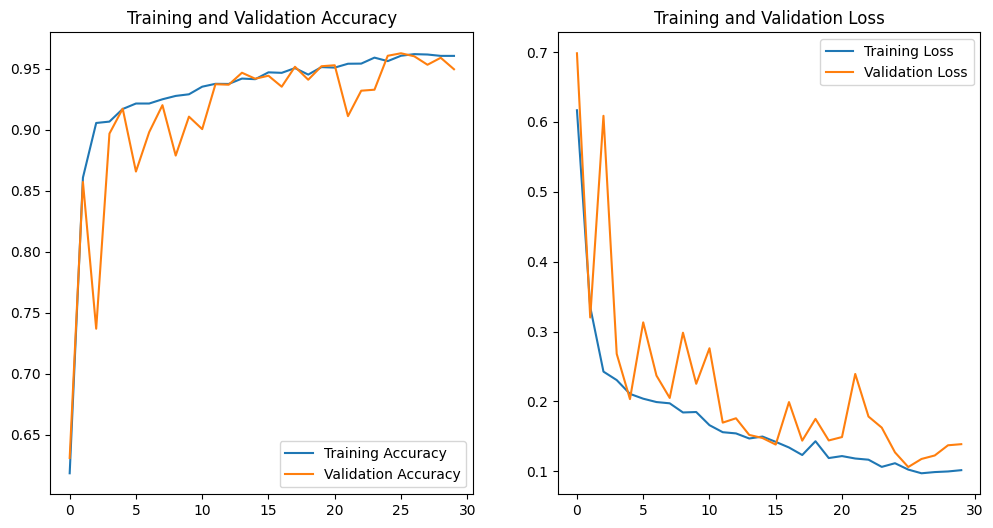

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
y_true, y_pred = eval_model_on_test(model)

Found 1358 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:00<00:03,  2.37it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  3.20it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.77it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.24it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:01,  4.46it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  4.72it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  5.06it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  5.33it/s]

3/3 [==============================] - 0s 7ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.19it/s]


In [29]:
y_pred = [1 if p > 0.5 else 0 for p in y_pred]

In [30]:
print(classification_report(y_true, y_pred,
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

   no_damage       0.94      0.96      0.95       703
      damage       0.96      0.94      0.95       655

    accuracy                           0.95      1358
   macro avg       0.95      0.95      0.95      1358
weighted avg       0.95      0.95      0.95      1358



,0,1
0,676,27
1,41,614


## Experiment 3 - Basic CNN 3 (Cao & Choe, 2018)

This is the CNN architecture from the paper Cao & Choe (2018)

https://arxiv.org/pdf/1807.01688.pdf

**adding their**

* Data augmentation
  * random rotation
  * horizontal flip
  * (vertical and horizontal shift) --> RandomTranslation
  * (shear) --> not clear how to add it using TF/Keras
  * zoom
* Dropout layer
  * Droput of 50% before dense layers --> same in paper
* L2 Regularization
  * L2 regularization with lambda = 10^-6 --> same in paper

In [31]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    layers.experimental.preprocessing.RandomZoom(0.2)
    ])

In [32]:
model = Sequential([

    data_augmentation,

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dropout(0.5),

    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(10e-6)),
    layers.Dense(1, activation='sigmoid')

    ])

In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)      

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
            )

In [35]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 10,
                                                  restore_best_weights = True)

epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [early_stopping_cb]
)

Epoch 1/30
306/306 [==============================] - 12s 27ms/step - loss: 0.5187 - accuracy: 0.7224 - val_loss: 0.4183 - val_accuracy: 0.8356
Epoch 2/30
306/306 [==============================] - 9s 28ms/step - loss: 0.2679 - accuracy: 0.8976 - val_loss: 0.3390 - val_accuracy: 0.8511
Epoch 3/30
306/306 [==============================] - 9s 28ms/step - loss: 0.2346 - accuracy: 0.9103 - val_loss: 0.2690 - val_accuracy: 0.8859
Epoch 4/30
306/306 [==============================] - 8s 27ms/step - loss: 0.2249 - accuracy: 0.9169 - val_loss: 0.2125 - val_accuracy: 0.9162
Epoch 5/30
306/306 [==============================] - 8s 27ms/step - loss: 0.2141 - accuracy: 0.9168 - val_loss: 0.2134 - val_accuracy: 0.9137
Epoch 6/30
306/306 [==============================] - 10s 32ms/step - loss: 0.1982 - accuracy: 0.9249 - val_loss: 0.2987 - val_accuracy: 0.8765
Epoch 7/30
306/306 [==============================] - 9s 28ms/step - loss: 0.1893 - accuracy: 0.9285 - val_loss: 0.1924 - val_accuracy: 0.91

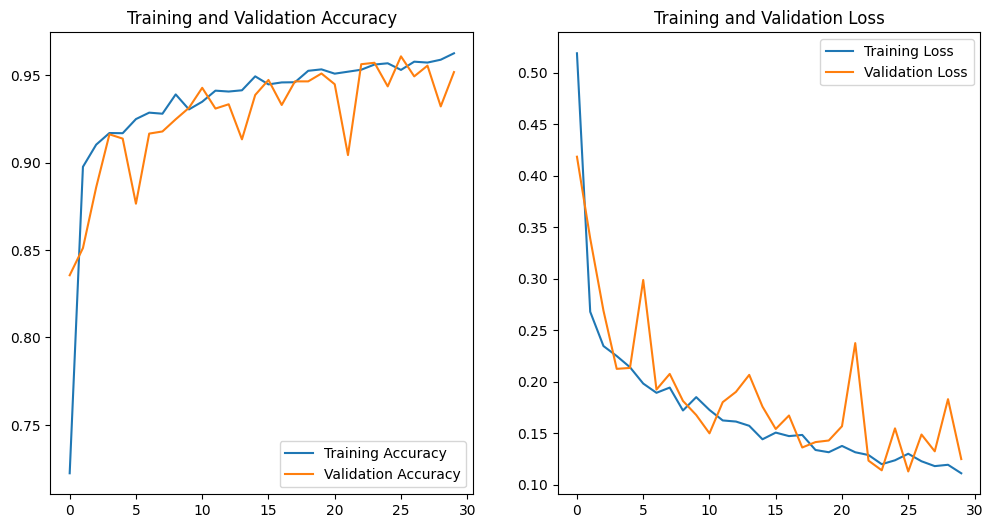

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
y_true, y_pred = eval_model_on_test(model)

Found 1358 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:04,  2.21it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:00<00:02,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:01,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:00<00:01,  5.51it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:00<00:00,  6.18it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  6.56it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  6.92it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:01<00:00,  7.12it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00,  6.97it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:01<00:00,  6.95it/s]

3/3 [==============================] - 0s 7ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  5.85it/s]


In [38]:
y_pred = [1 if p > 0.5 else 0 for p in y_pred]

In [39]:
print(classification_report(y_true, y_pred,
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

   no_damage       0.95      0.96      0.95       703
      damage       0.96      0.94      0.95       655

    accuracy                           0.95      1358
   macro avg       0.95      0.95      0.95      1358
weighted avg       0.95      0.95      0.95      1358



,0,1
0,676,27
1,37,618


## Experiment 4 - Transfer Learning

